In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random
import cv2
import pandas as pd
import numpy as np

In [2]:
import sys
import os
import importlib

In [3]:
def find_project_root():
    current_path = os.getcwd()
    while True:
        if os.path.exists(os.path.join(current_path, 'src')):
            return current_path
        parent = os.path.dirname(current_path)
        if parent == current_path:
            raise FileNotFoundError("❌ Không tìm thấy folder dự án!")
        current_path = parent

try:
    project_root = find_project_root()
    src_path = os.path.join(project_root, 'src')
    if project_root not in sys.path:
        sys.path.insert(0, project_root)
    
    if src_path not in sys.path:
        sys.path.insert(0, src_path)
        
    print(f"✅ Đã thêm path:\n - {project_root}\n - {src_path}")
    
    # 3. CHUYỂN NHÀ VỀ ROOT
    os.chdir(project_root)

    # 4. IMPORT VÀ RELOAD
    import src.data_module
    importlib.reload(src.data_module)
    
    from src.data_module import create_dataloaders, GeoDataset
    from src.utils import load_config
    print("🚀 IMPORT THÀNH CÔNG! (Cuối cùng cũng xong)")
    
except Exception as e:
    print(f"☠️ Lỗi: {e}")

✅ Đã thêm path:
 - c:\Users\VICTUS\Documents\developer\self-learning\cv-agricultural-land-classification
 - c:\Users\VICTUS\Documents\developer\self-learning\cv-agricultural-land-classification\src
🚀 IMPORT THÀNH CÔNG! (Cuối cùng cũng xong)


c:\Users\VICTUS\Documents\developer\self-learning\cv-agricultural-land-classification\src\data_module.py:35: UserWarning: Argument(s) 'fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(


## 1. Configuration loads and raw dataset loads

In [4]:
data_config_info = load_config(
    r'config/data_config.yml'
)
raw_dataset = GeoDataset(
    data_config=data_config_info
)

In [5]:
print(f"Số cột trong dataset: {list(raw_dataset.dataset.keys())}")
num_samples = len(raw_dataset.dataset['image'])
print(f"✅ Số mẫu thực tế (số ảnh): {num_samples}")

Số cột trong dataset: ['image', 'path', 'class', 'label_idx']
✅ Số mẫu thực tế (số ảnh): 6000


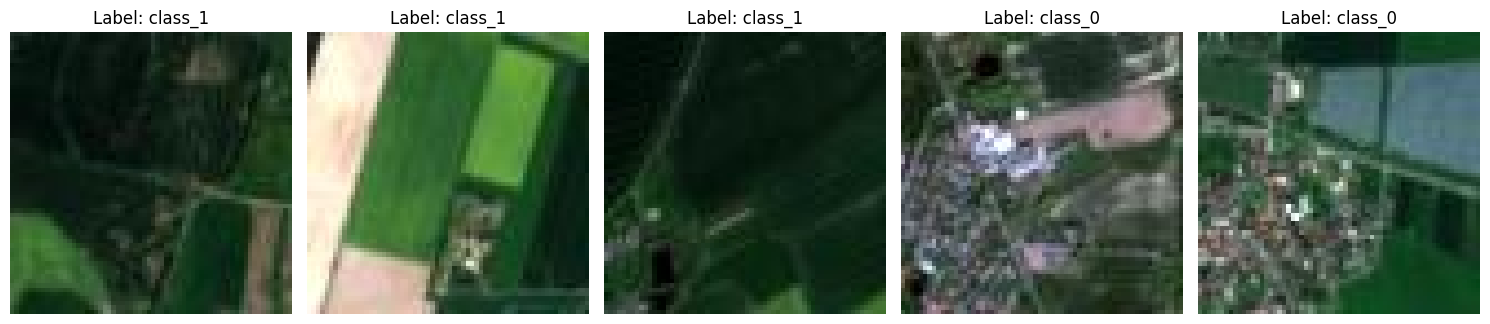

In [6]:
images = raw_dataset.dataset['image']
labels = raw_dataset.dataset['class']
paths = raw_dataset.dataset['path']

# Chọn ngẫu nhiên 5 chỉ số
random_indices = random.sample(range(num_samples), 5)

plt.figure(figsize=(15, 5))

for i, idx in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    img = images[idx] 
    
    plt.imshow(img)
    plt.title(f"Label: {labels[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 2. Dataset augmentation

In [7]:
from src.data_module import train_transform, val_transform

In [8]:
def denormalize(img_tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img_tensor.permute(1, 2, 0).numpy()
    img = (img * std + mean)
    return np.clip(img, 0, 1)

✅ Type sau khi ép: <class 'numpy.ndarray'>
✅ Shape: (64, 64, 3)


error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'flip'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


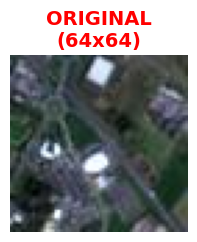

In [10]:
# 1. Lấy dữ liệu
sample_data = raw_dataset.dataset['image'][0]

# 2. XỬ LÝ DỮ LIỆU (FIX CỨNG TAY)
try:
    if isinstance(sample_data, str): 
        # Nếu là đường dẫn -> Đọc
        sample_img_numpy = cv2.imread(sample_data)
        sample_img_numpy = cv2.cvtColor(sample_img_numpy, cv2.COLOR_BGR2RGB)
    else:
        # Nếu đã là array (hoặc cái gì đó giống array)
        # ⚠️ DÒNG QUAN TRỌNG NHẤT: Ép nó về np.array của phiên bản hiện tại
        sample_img_numpy = np.array(sample_data)

    # Check lại lần cuối cho chắc
    print(f"✅ Type sau khi ép: {type(sample_img_numpy)}")
    print(f"✅ Shape: {sample_img_numpy.shape}")

except Exception as e:
    raise ValueError(f"❌ Không xử lý được dữ liệu: {e}")

# --- 3. VẼ (Code cũ giữ nguyên) ---
plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(2, 6)

# Ảnh gốc
ax_orig = plt.subplot(gs[:, 0]) 
ax_orig.imshow(sample_img_numpy)
ax_orig.set_title(f"ORIGINAL\n(64x64)", fontsize=14, fontweight='bold', color='red')
ax_orig.axis('off')

# Ảnh Augment
for i in range(10):
    row = i // 5 
    col = (i % 5) + 1 
    
    # Lúc này sample_img_numpy đã là "con đẻ" của numpy hiện tại,
    # Albumentations không cãi được nữa!
    augmented = train_transform(image=sample_img_numpy)['image']
    view_img = denormalize(augmented)
    
    ax = plt.subplot(gs[row, col])
    ax.imshow(view_img)
    ax.set_title(f"Aug {i+1}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## 3. Create Dataloader

In [ ]:
data_config_info = load_config(
    r'config/data_config.yml'
)

In [ ]:
train_loader, eval_loader, test_loader = create_dataloaders(
    data_config=data_config_info
)

📊 Chia tập dữ liệu: Train=5400, Val=300, Test=300
